# Imports

In [49]:
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from keras.models import load_model
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    GlobalAveragePooling2D,
    Dense
)
from tensorflow.keras.optimizers import Adam

# Constants

In [50]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10

train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

# Function to create data generators

In [51]:
def create_data_generators(phase):
    if phase == 3:  # Data augmentation for Phase 3
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
    else:  # Only scaling for Phase 1 and Phase 2
        train_datagen = ImageDataGenerator(rescale=1. / 255)

    val_test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

# Function to train a model

In [52]:
def train_model(
        model,
        train_gen,
        val_gen,
        epochs: int = 20,
        phase: int = 1
):
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
    callbacks = [early_stopping]
    if phase == 3:
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
        callbacks.append(reduce_lr)

        # model_checkpoint = ModelCheckpoint(
        #     f'phase_{phase}_best_model.h5',
        #     monitor='val_loss',
        #     save_best_only=True,
        #     verbose=1
        # )
        # callbacks.append(model_checkpoint)

    # Train the model with or without callbacks
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )
    return history

# Function to plot learning curves

In [53]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Function to evaluate the model

In [54]:
def evaluate_model(model, test_gen):
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    y_true_binary = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 8))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {list(test_gen.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# visualize predictions

In [55]:
def visualize_random_predictions(model, test_gen, num_images=10):
    x_test, y_test = next(test_gen)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Randomly select indices
    random_indices = random.sample(range(len(x_test)), min(num_images, len(x_test)))

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]))  # Squeeze in case of single-channel images
        true_label = list(test_gen.class_indices.keys())[y_true_classes[idx]]
        pred_label = list(test_gen.class_indices.keys())[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Phase 1: Model with 1,400,000 parameters (no data augmentation)

In [56]:
def create_phase_1_model(
        input_shape=(128, 128, 3),
        num_classes=10,
        learning_rate=1e-3
):
    model = Sequential(name="Animals10_CNN_Under1_4M")

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.3))

    # Global Average Pooling instead of Flatten to reduce parameter count
    model.add(GlobalAveragePooling2D())

    # Dense block
    model.add(Dense(7000, activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

# Phase 2: Adjusted model with 400,000 parameters (reuse Phase 1 architecture)

In [71]:
def create_phase_2_model(
        input_shape=(128, 128, 3),
        num_classes=10,
        learning_rate=1e-3
):
    model = Sequential(name="Animals10_CNN_Under_400k")

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.3))

    # Global Average Pooling instead of Flatten to reduce parameter count
    model.add(GlobalAveragePooling2D())

    # Dense block
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [58]:
def create_phase_3_model_1(
        input_shape=(128, 128, 3),
        num_classes=10
):
    model = Sequential(name="phase_3_model_1")

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Global Average Pooling instead of Flatten to reduce parameter count
    model.add(GlobalAveragePooling2D())

    # Dense block
    model.add(Dense(7000, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [59]:
def create_phase_3_model_2(
        input_shape=(128, 128, 3),
        num_classes=10
):
    model = Sequential(name="phase_3_model_2")

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Global Average Pooling instead of Flatten to reduce parameter count
    model.add(GlobalAveragePooling2D())

    # Dense block
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Phase 3: Overfitting prevention

In [60]:
def apply_overfitting_prevention(model):
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer.kernel_regularizer = regularizers.l2(0.001)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Execution for Phase 1

In [61]:
train_generator, val_generator, test_generator = create_data_generators(phase=1)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [62]:
model_phase_1 = create_phase_1_model()

In [63]:
model_phase_1.summary()

Model: "Animals10_CNN_Under1_4M"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                           

In [64]:
history_phase_1 = train_model(model_phase_1, train_generator, val_generator, phase=1)

Epoch 1/20
530/530 [==============================] - 572s 1s/step - loss: 2.5381 - accuracy: 0.3200 - val_loss: 2.3330 - val_accuracy: 0.3344
Epoch 2/20
530/530 [==============================] - 584s 1s/step - loss: 2.0373 - accuracy: 0.4330 - val_loss: 3.9893 - val_accuracy: 0.1988
Epoch 3/20
530/530 [==============================] - 574s 1s/step - loss: 1.7123 - accuracy: 0.5315 - val_loss: 2.0278 - val_accuracy: 0.5113
Epoch 4/20
530/530 [==============================] - 561s 1s/step - loss: 1.3948 - accuracy: 0.6034 - val_loss: 1.7140 - val_accuracy: 0.5584
Epoch 5/20
530/530 [==============================] - 600s 1s/step - loss: 1.1674 - accuracy: 0.6542 - val_loss: 1.5915 - val_accuracy: 0.5802
Epoch 6/20
530/530 [==============================] - 606s 1s/step - loss: 0.9051 - accuracy: 0.7115 - val_loss: 1.1561 - val_accuracy: 0.6532
Epoch 7/20
530/530 [==============================] - 740s 1s/step - loss: 0.7620 - accuracy: 0.7508 - val_loss: 1.5159 - val_accuracy: 0.5649

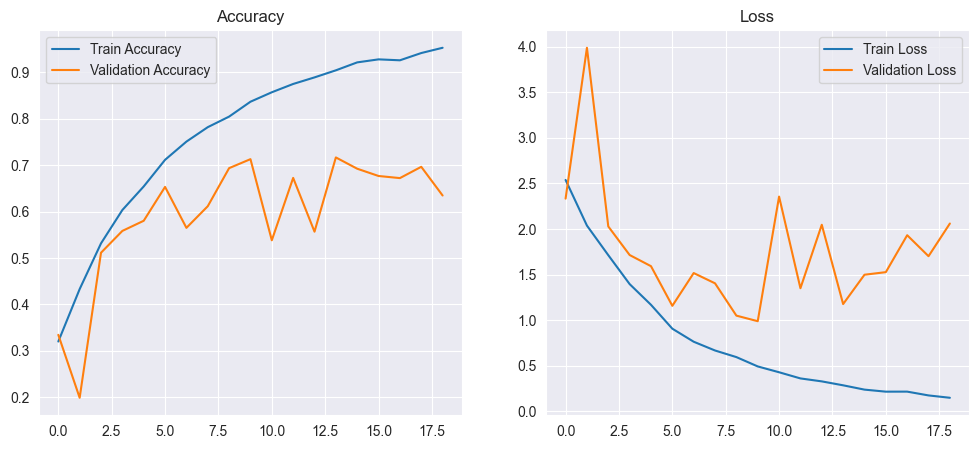

In [65]:
plot_learning_curves(history_phase_1)

152/152 [==============================] - 35s 227ms/step - loss: 1.1465 - accuracy: 0.7276
Test Loss: 1.1465283632278442
Test Accuracy: 0.7276104092597961
152/152 [==============================] - 35s 225ms/step


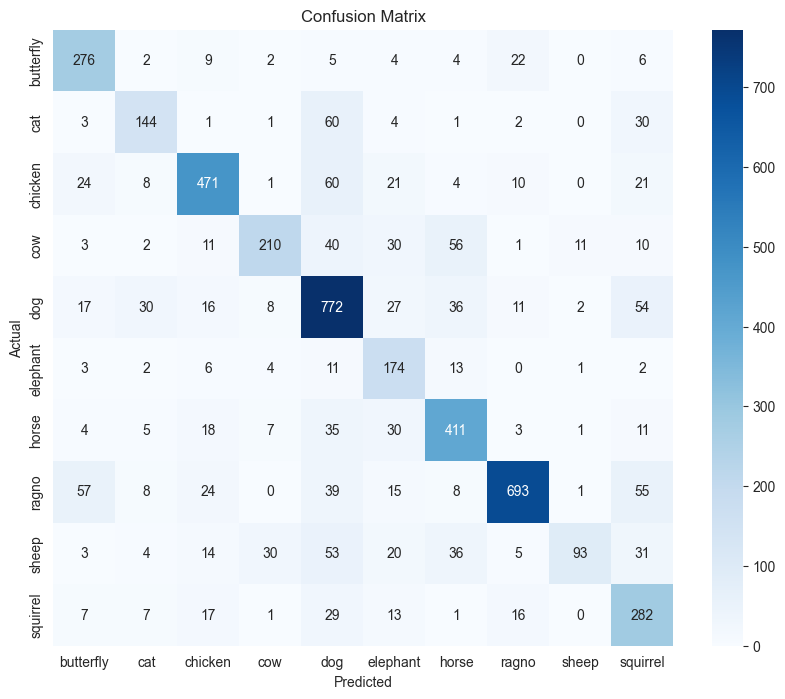

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.70      0.84      0.76       330
         cat       0.68      0.59      0.63       246
     chicken       0.80      0.76      0.78       620
         cow       0.80      0.56      0.66       374
         dog       0.70      0.79      0.74       973
    elephant       0.51      0.81      0.63       216
       horse       0.72      0.78      0.75       525
       ragno       0.91      0.77      0.83       900
       sheep       0.85      0.32      0.47       289
    squirrel       0.56      0.76      0.64       373

    accuracy                           0.73      4846
   macro avg       0.72      0.70      0.69      4846
weighted avg       0.75      0.73      0.73      4846



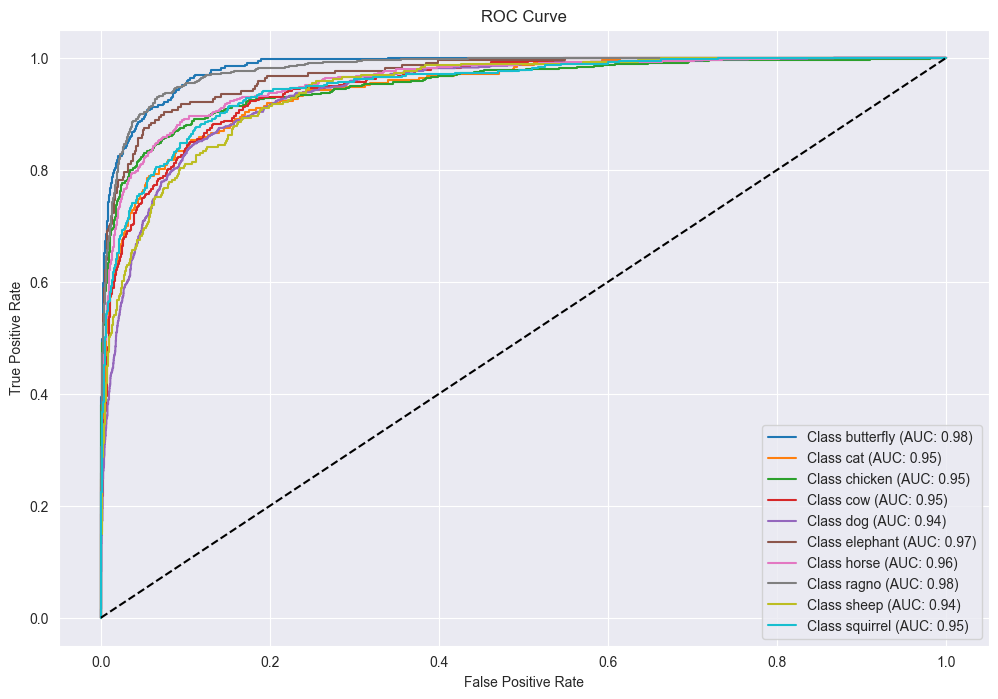

In [66]:
evaluate_model(model_phase_1, test_generator)

1/1 [==============================] - 1s 754ms/step


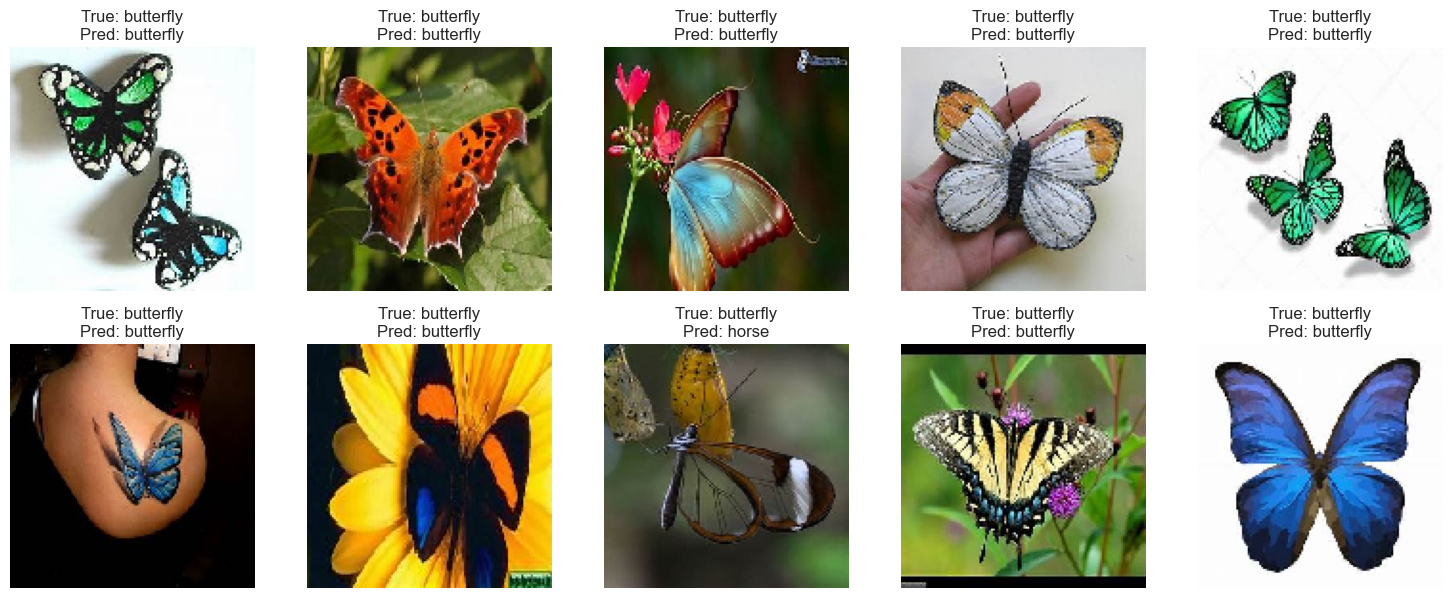

In [67]:
visualize_random_predictions(model_phase_1, test_generator)

# Execution for Phase 2

In [72]:
model_phase_2 = create_phase_2_model()

In [73]:
model_phase_2.summary()

Model: "Animals10_CNN_Under_400k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_11 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                          

In [74]:
history_phase_2 = train_model(model_phase_2, train_generator, val_generator, phase=2)

Epoch 1/20
530/530 [==============================] - 520s 977ms/step - loss: 1.7480 - accuracy: 0.4045 - val_loss: 1.7743 - val_accuracy: 0.3971
Epoch 2/20
530/530 [==============================] - 523s 986ms/step - loss: 1.3315 - accuracy: 0.5403 - val_loss: 1.9040 - val_accuracy: 0.3753
Epoch 3/20
530/530 [==============================] - 519s 979ms/step - loss: 1.1237 - accuracy: 0.6145 - val_loss: 1.4981 - val_accuracy: 0.5299
Epoch 4/20
530/530 [==============================] - 519s 980ms/step - loss: 0.9354 - accuracy: 0.6807 - val_loss: 1.1278 - val_accuracy: 0.6115
Epoch 5/20
530/530 [==============================] - 553s 1s/step - loss: 0.7893 - accuracy: 0.7316 - val_loss: 1.5725 - val_accuracy: 0.5872
Epoch 6/20
530/530 [==============================] - 578s 1s/step - loss: 0.6611 - accuracy: 0.7783 - val_loss: 1.1301 - val_accuracy: 0.6491
Epoch 7/20
530/530 [==============================] - 582s 1s/step - loss: 0.5600 - accuracy: 0.8120 - val_loss: 1.1526 - val_accu

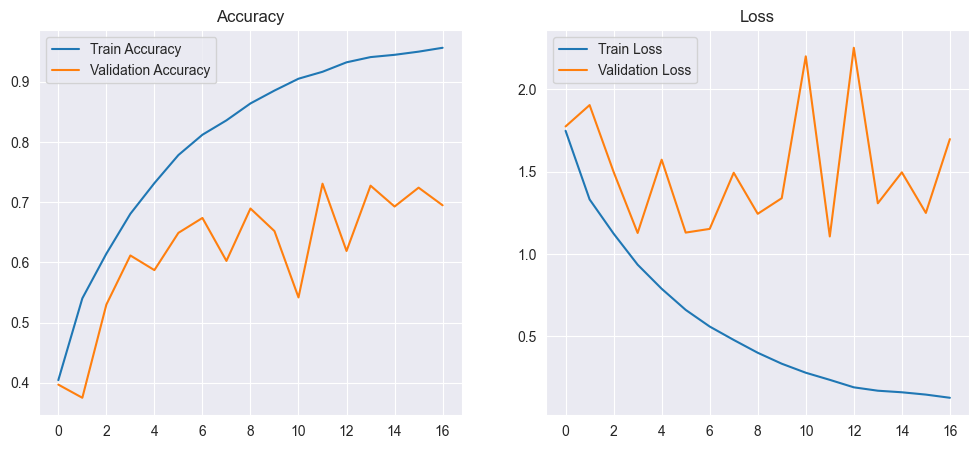

In [75]:
plot_learning_curves(history_phase_2)

152/152 [==============================] - 35s 228ms/step - loss: 1.0755 - accuracy: 0.7317
Test Loss: 1.0754510164260864
Test Accuracy: 0.731737494468689
152/152 [==============================] - 35s 226ms/step


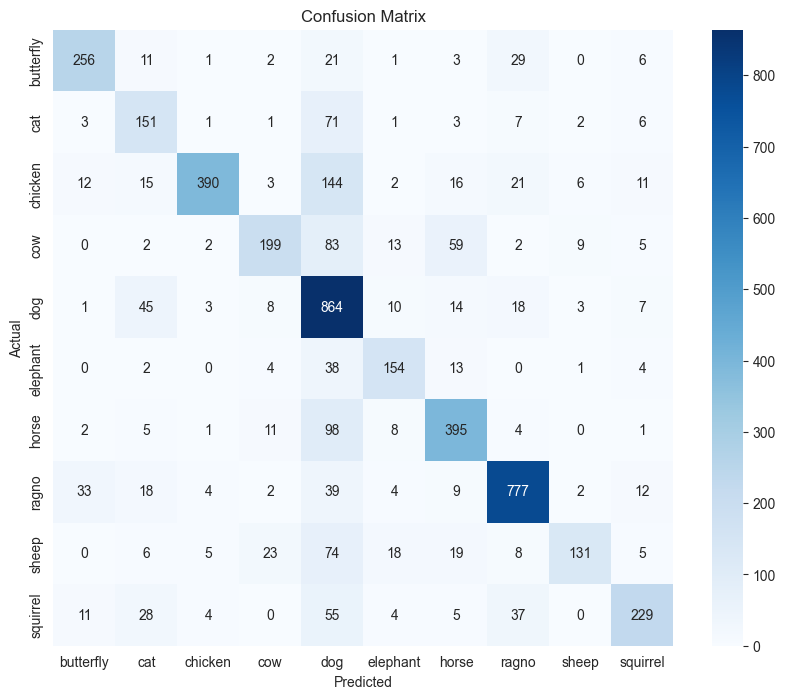

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.81      0.78      0.79       330
         cat       0.53      0.61      0.57       246
     chicken       0.95      0.63      0.76       620
         cow       0.79      0.53      0.63       374
         dog       0.58      0.89      0.70       973
    elephant       0.72      0.71      0.71       216
       horse       0.74      0.75      0.74       525
       ragno       0.86      0.86      0.86       900
       sheep       0.85      0.45      0.59       289
    squirrel       0.80      0.61      0.69       373

    accuracy                           0.73      4846
   macro avg       0.76      0.68      0.71      4846
weighted avg       0.76      0.73      0.73      4846



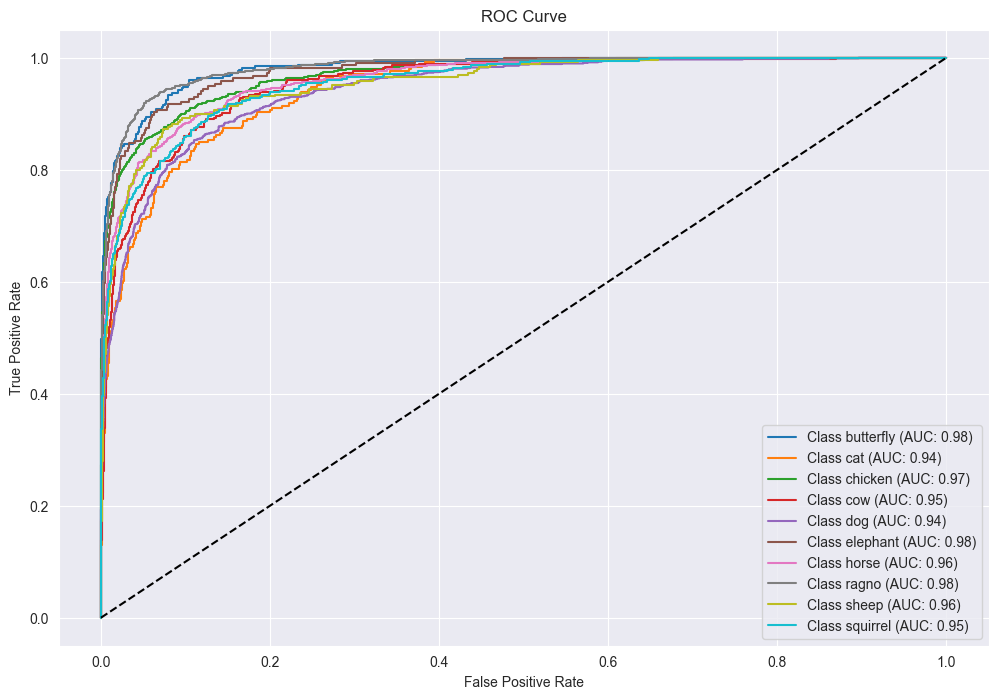

In [76]:
evaluate_model(model_phase_2, test_generator)

1/1 [==============================] - 0s 350ms/step


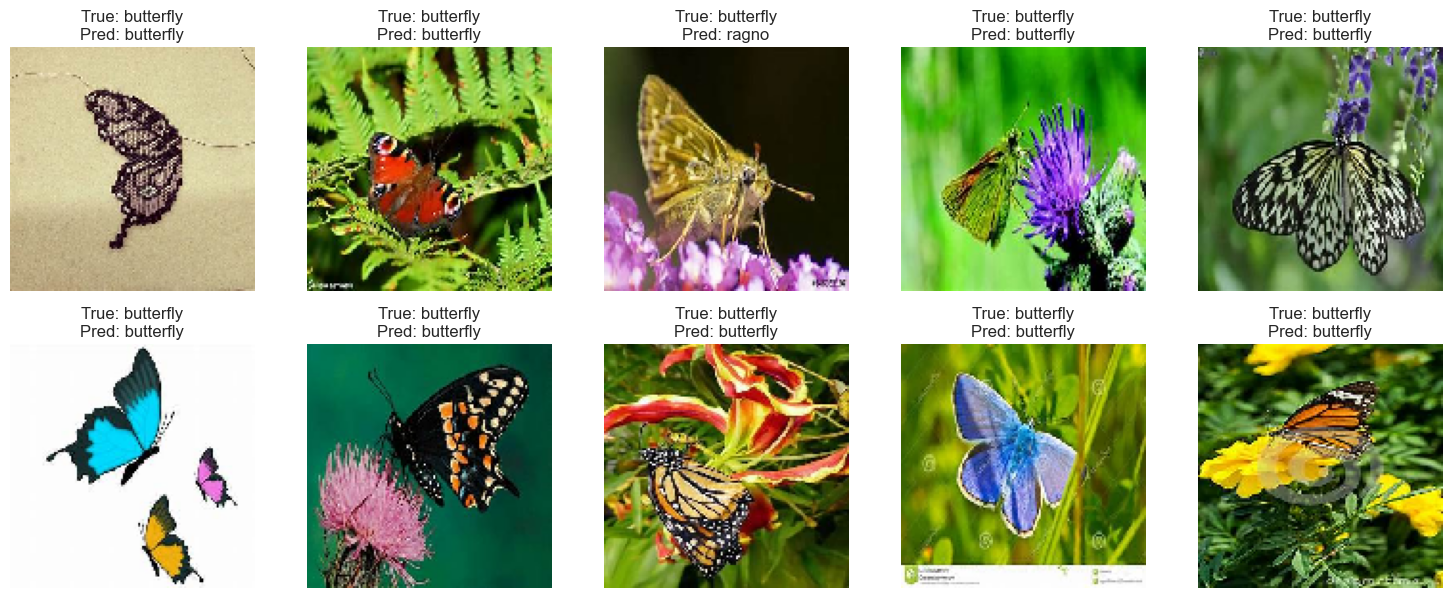

In [77]:
visualize_random_predictions(model_phase_2, test_generator)

# Execution for Phase 3: Prevent Overfitting (Phase 1 and Phase 2 models)

In [78]:
train_generator, val_generator, test_generator = create_data_generators(phase=3)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [79]:
model_phase_3_1 = create_phase_3_model_1()
model_phase_3_1 = apply_overfitting_prevention(model_phase_3_1)
history_phase3_1 = train_model(model_phase_3_1, train_generator, val_generator, phase=3)
model_phase_3_1.save("phase_3_model_1.keras")

Epoch 1/20
530/530 [==============================] - 649s 1s/step - loss: 2.3516 - accuracy: 0.2778 - val_loss: 3.8113 - val_accuracy: 0.1926 - lr: 1.0000e-04
Epoch 2/20
530/530 [==============================] - 656s 1s/step - loss: 2.0231 - accuracy: 0.3518 - val_loss: 3.3742 - val_accuracy: 0.2771 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - 654s 1s/step - loss: 1.8693 - accuracy: 0.3900 - val_loss: 3.5961 - val_accuracy: 0.2804 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - 635s 1s/step - loss: 1.7421 - accuracy: 0.4185 - val_loss: 3.4703 - val_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 5/20
530/530 [==============================] - 612s 1s/step - loss: 1.6625 - accuracy: 0.4449 - val_loss: 2.8939 - val_accuracy: 0.3480 - lr: 1.0000e-04
Epoch 6/20
530/530 [==============================] - 614s 1s/step - loss: 1.5740 - accuracy: 0.4726 - val_loss: 3.5292 - val_accuracy: 0.3031 - lr: 1.0000e-04
Epoch 7/20
530/530 [====================

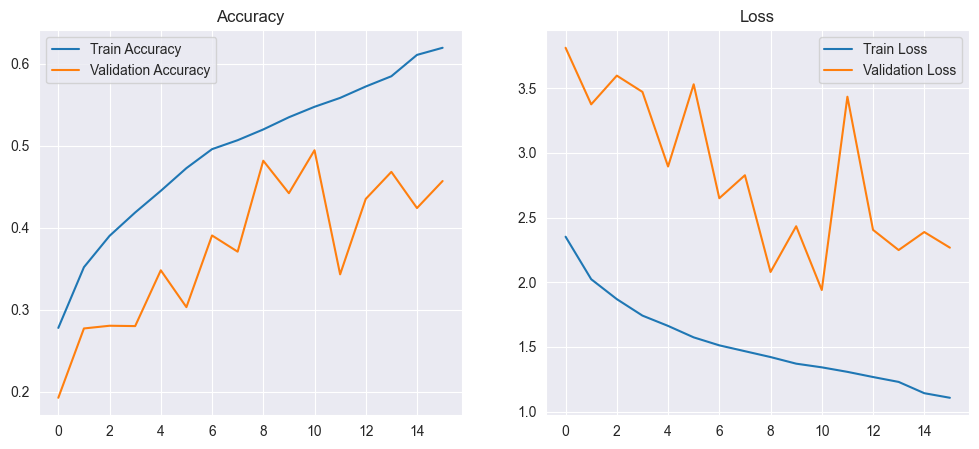

In [80]:
plot_learning_curves(history_phase3_1)

152/152 [==============================] - 35s 228ms/step - loss: 1.8993 - accuracy: 0.4917
Test Loss: 1.8992573022842407
Test Accuracy: 0.4917457699775696
152/152 [==============================] - 35s 230ms/step


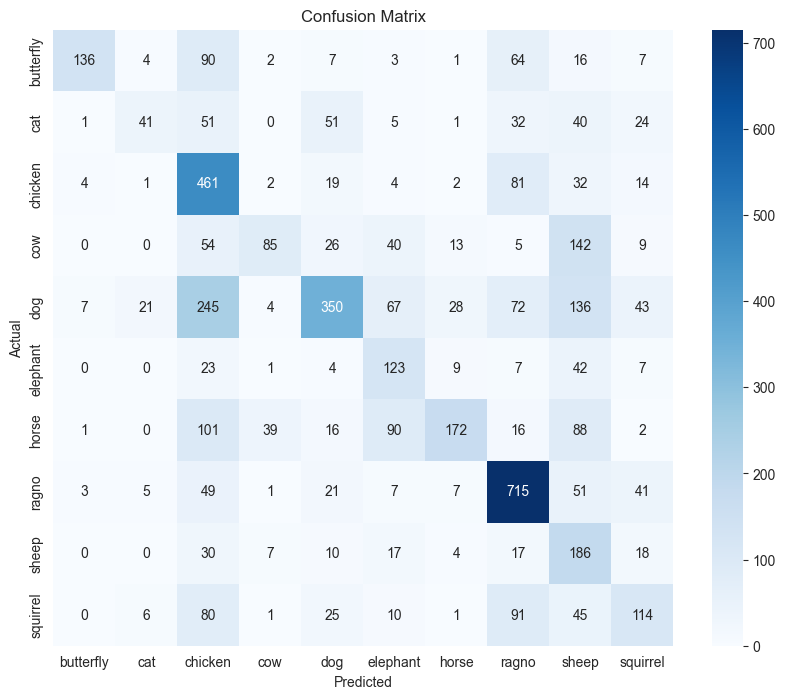

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.89      0.41      0.56       330
         cat       0.53      0.17      0.25       246
     chicken       0.39      0.74      0.51       620
         cow       0.60      0.23      0.33       374
         dog       0.66      0.36      0.47       973
    elephant       0.34      0.57      0.42       216
       horse       0.72      0.33      0.45       525
       ragno       0.65      0.79      0.71       900
       sheep       0.24      0.64      0.35       289
    squirrel       0.41      0.31      0.35       373

    accuracy                           0.49      4846
   macro avg       0.54      0.46      0.44      4846
weighted avg       0.58      0.49      0.48      4846



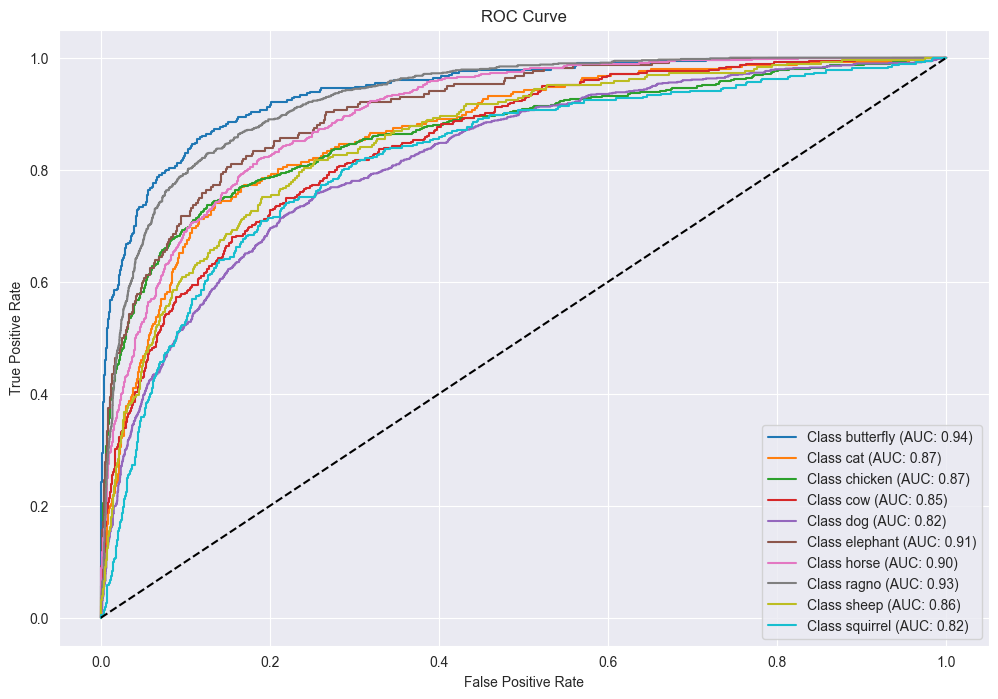

In [81]:
evaluate_model(model_phase_3_1, test_generator)

1/1 [==============================] - 0s 354ms/step


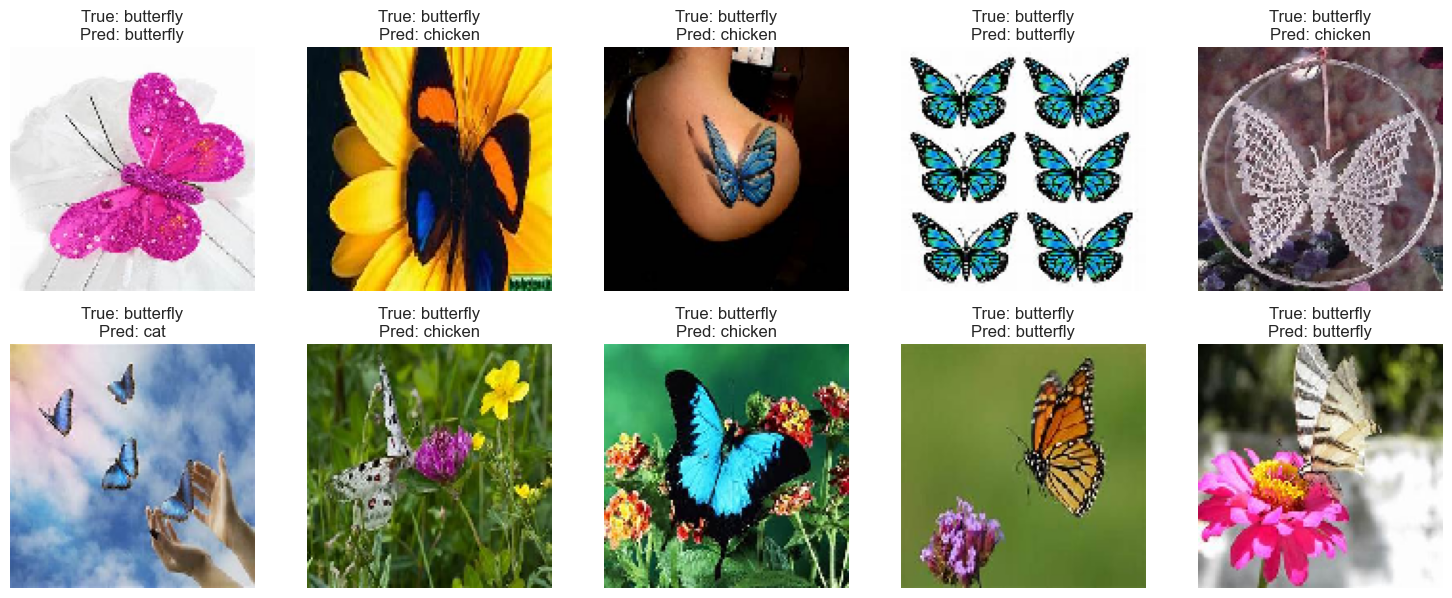

In [82]:
visualize_random_predictions(model_phase_3_1, test_generator)

In [83]:
model_phase_3_2 = create_phase_3_model_2()
model_phase_3_2 = apply_overfitting_prevention(model_phase_3_2)
history_phase3_2 = train_model(model_phase_3_2, train_generator, val_generator, phase=3)
model_phase_3_2.save("phase_3_model_2.keras")

Epoch 1/20
530/530 [==============================] - 582s 1s/step - loss: 2.6014 - accuracy: 0.2174 - val_loss: 3.8200 - val_accuracy: 0.1715 - lr: 1.0000e-04
Epoch 2/20
530/530 [==============================] - 579s 1s/step - loss: 2.2417 - accuracy: 0.2936 - val_loss: 3.6359 - val_accuracy: 0.2153 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - 597s 1s/step - loss: 2.0515 - accuracy: 0.3335 - val_loss: 3.6621 - val_accuracy: 0.2099 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - 604s 1s/step - loss: 1.9262 - accuracy: 0.3597 - val_loss: 3.6392 - val_accuracy: 0.2544 - lr: 1.0000e-04
Epoch 5/20
530/530 [==============================] - 597s 1s/step - loss: 1.8289 - accuracy: 0.3900 - val_loss: 4.4482 - val_accuracy: 0.2478 - lr: 1.0000e-04
Epoch 6/20
530/530 [==============================] - 609s 1s/step - loss: 1.7151 - accuracy: 0.4218 - val_loss: 3.2241 - val_accuracy: 0.2800 - lr: 2.0000e-05
Epoch 7/20
530/530 [====================

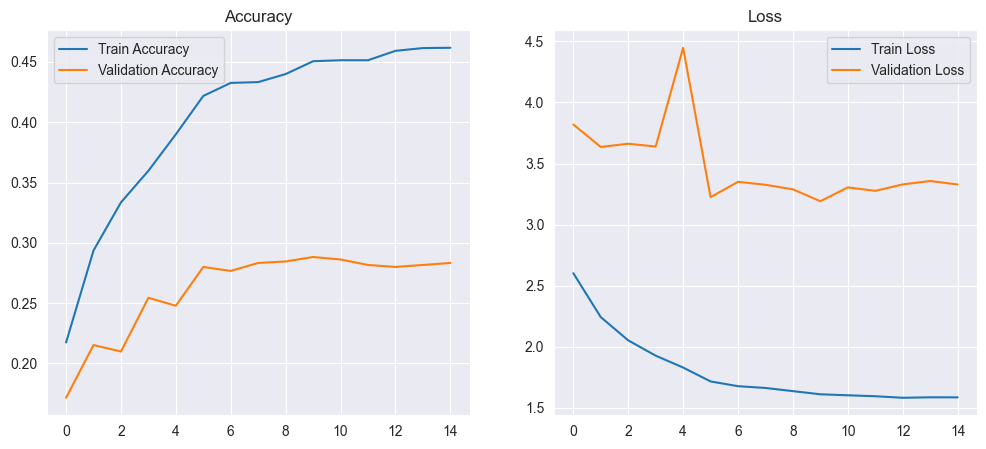

In [84]:
plot_learning_curves(history_phase3_2)

152/152 [==============================] - 34s 221ms/step - loss: 3.2601 - accuracy: 0.2745
Test Loss: 3.260146379470825
Test Accuracy: 0.27445316314697266
152/152 [==============================] - 34s 224ms/step


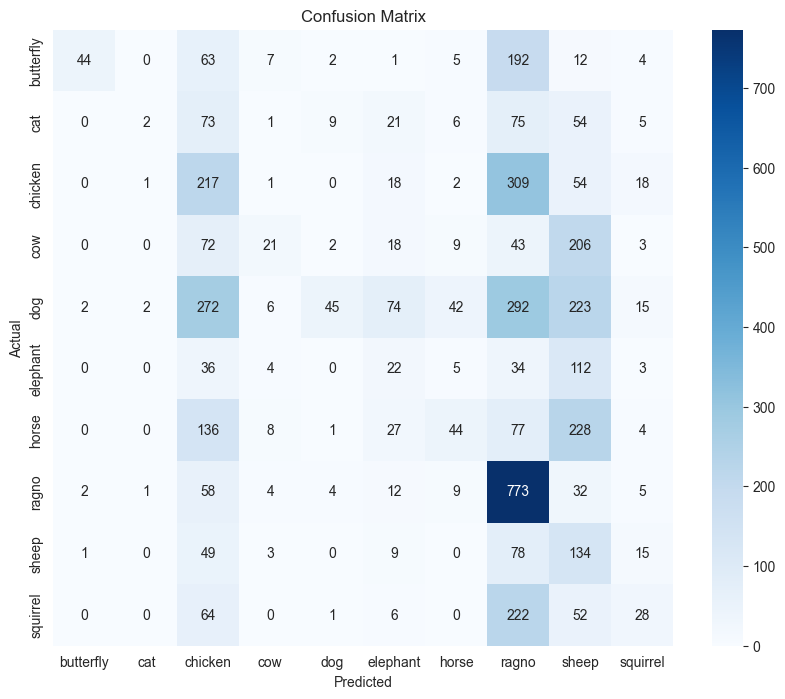

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.90      0.13      0.23       330
         cat       0.33      0.01      0.02       246
     chicken       0.21      0.35      0.26       620
         cow       0.38      0.06      0.10       374
         dog       0.70      0.05      0.09       973
    elephant       0.11      0.10      0.10       216
       horse       0.36      0.08      0.14       525
       ragno       0.37      0.86      0.52       900
       sheep       0.12      0.46      0.19       289
    squirrel       0.28      0.08      0.12       373

    accuracy                           0.27      4846
   macro avg       0.38      0.22      0.18      4846
weighted avg       0.42      0.27      0.21      4846



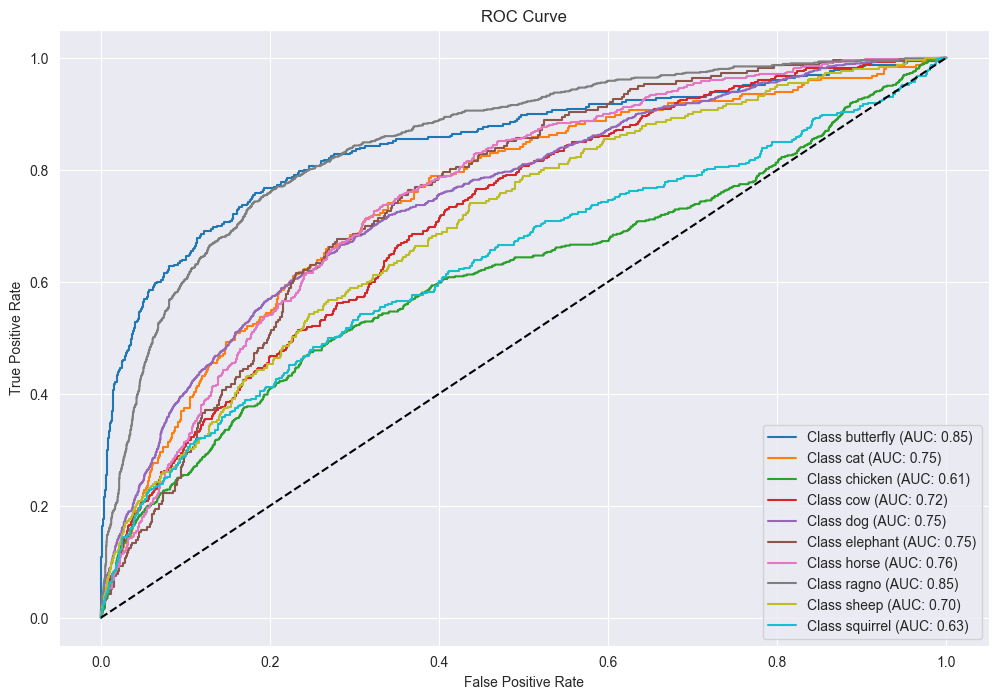

In [85]:
evaluate_model(model_phase_3_2, test_generator)

1/1 [==============================] - 0s 311ms/step


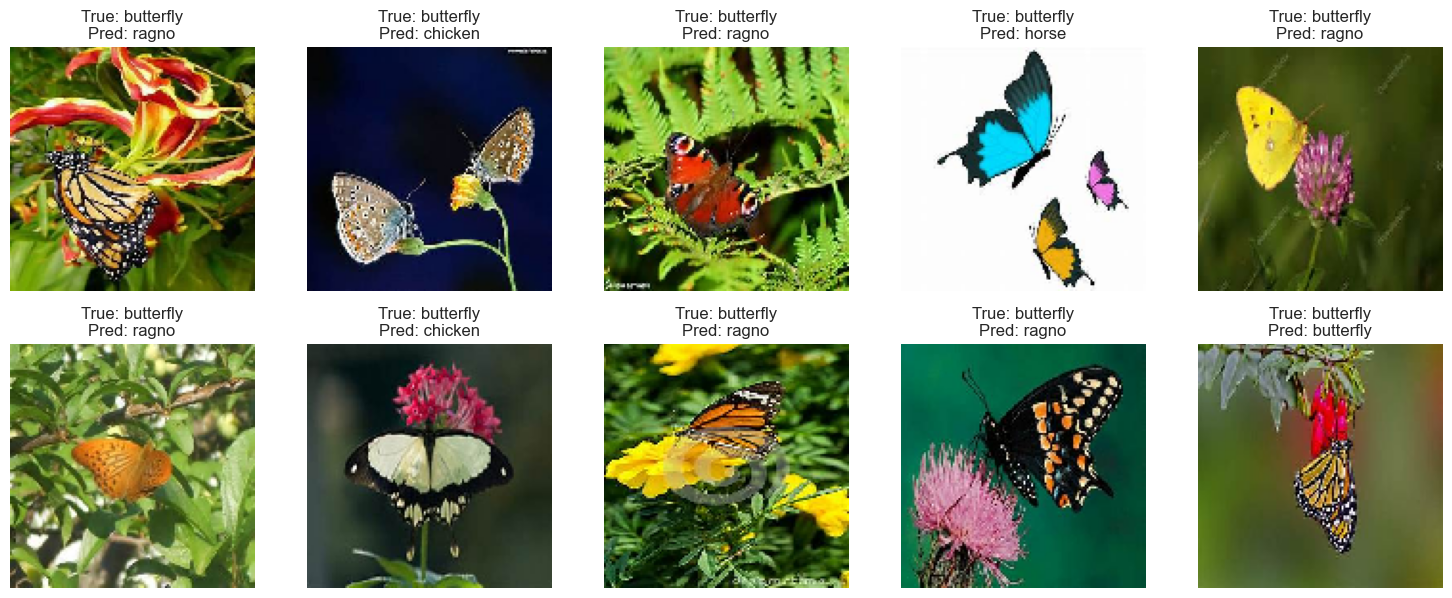

In [86]:
visualize_random_predictions(model_phase_3_2, test_generator)